In [1]:
using ForneyLab
using ForneyLab:prod!
using Plots
using Random
Random.seed!(0)
;

┌ Info: Precompiling ForneyLab [9fc3f58a-c2cc-5bff-9419-6a294fefdca9]
└ @ Base loading.jl:1278
┌ Warning: Package ForneyLab does not have Flux in its dependencies:
│ - If you have ForneyLab checked out for development and have
│   added Flux as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ForneyLab
└ Loading Flux into ForneyLab from project dependency, future warnings for ForneyLab are suppressed.


In [2]:
# A Wide Gaussian forward message
forw(x) = exp(logPdf(ProbabilityDistribution(Univariate,GaussianMeanVariance,m=-5,v=100),x))

# A multimodal backward message
back(x) = exp(logPdf(ProbabilityDistribution(Univariate,Gamma,a=6,b=0.5),abs(x))) +
       exp(logPdf(ProbabilityDistribution(Univariate,GaussianMeanVariance,m=4,v=2.5),x))*2

# logpdf of messages
logforw(x) = log(forw(x))
logback(x) = log(back(x))

# unnormalized posterior pdf
post(x) = forw(x)*back(x)
;

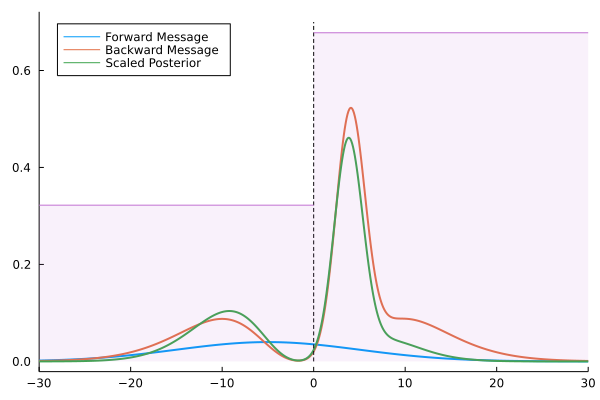

In [3]:
#Plot
xrange = collect(-30:0.1:30)
plot(xrange,forw.(xrange),label="Forward Message",lw=2,color=:orange,c=1)
plot!(xrange,back.(xrange),label="Backward Message",lw=2,color=:blue,grid=false,c=2)
plot!(xrange,33.0.*post.(xrange),label="Scaled Posterior",lw=2,color=:green,grid=false,c=3,xlim=(-30,30))
vol1 = sum(post.(collect(-100:0.01:0)))
vol2 = sum(post.(collect(0:0.01:100)))
volume1 = vol1/(vol1+vol2)
volume2 = vol2/(vol1+vol2)
plot!(zeros(71),collect(0:0.01:0.7),linestyle=:dash,label=false,color=:black)
plot!(collect(-30:0.1:0), volume1*ones(301), fillrange = zeros(301), fillalpha = 0.1, label = false, legend = :topleft, c=4)
plot!(collect(0:0.1:30), volume2*ones(301), fillrange = zeros(301), fillalpha = 0.1, label = false, legend = :topleft, c=4)

In [4]:
savefig("MultimodalProblem1.pdf")

In [5]:
m_forw = ProbabilityDistribution(Univariate, GaussianMeanVariance,m=-5.,v=100)
m_back = ProbabilityDistribution(Univariate, Function, log_pdf=(x)->logback(x))
;

# CVI

In [6]:
using Flux.Optimise, ForwardDiff
using ForneyLab: standardDist, naturalParams, VariateType, isProper

In [7]:
function renderCVI(logp_nc::Function,
                   num_iterations::Int,
                   opt::Union{Descent, Momentum, Nesterov, RMSProp, ADAM, ForgetDelayDescent},
                   msg_in::Message{F, V}) where {F<:Gaussian, V<:VariateType}

    η = deepcopy(naturalParams(msg_in.dist))
    λ = deepcopy(naturalParams(msg_in.dist))

    df_m(z) = ForwardDiff.derivative(logp_nc,z)
    df_v(z) = 0.5*ForwardDiff.derivative(df_m,z)

    for i=1:num_iterations
        #q = standardDistribution(V, F ,η=λ)
        q = standardDist(msg_in.dist,λ)
        z_s = sample(q)
        df_μ1 = df_m(z_s) - 2*df_v(z_s)*mean(q)
        df_μ2 = df_v(z_s)
        ∇f = [df_μ1, df_μ2]
        λ_old = deepcopy(λ)
        ∇ = λ .- η .- ∇f
        update!(opt,λ,∇)
        #if isProper(standardDistribution(V, F ,η=λ)) == false
        if isProper(standardDist(msg_in.dist,λ)) == false
            λ = λ_old
        end
    end

    #return standardDistribution(V, F ,η=λ)
    return standardDist(msg_in.dist,λ)

end

renderCVI (generic function with 1 method)

In [8]:
Random.seed!(0)
posterior1 = renderCVI(logback,100,Descent(0.05),Message(m_forw))
posterior2 = renderCVI(logback,1000,Descent(0.05),Message(m_forw))
posterior3 = renderCVI(logback,100000,Descent(0.05),Message(m_forw))
;

In [9]:
cvi1(x) = exp(logPdf(posterior1,x));
cvi2(x) = exp(logPdf(posterior2,x));
cvi3(x) = exp(logPdf(posterior3,x));

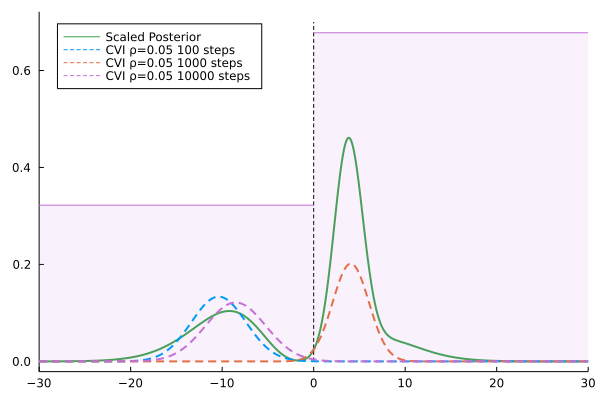

In [10]:
plot(xrange,33.0.*post.(xrange),label="Scaled Posterior",lw=2,color=:green,grid=false,c=3,xlim=(-30,30))
vol1 = sum(post.(collect(-100:0.01:0)))
vol2 = sum(post.(collect(0:0.01:100)))
volume1 = vol1/(vol1+vol2)
volume2 = vol2/(vol1+vol2)
plot!(zeros(71),collect(0:0.01:0.7),linestyle=:dash,label=false,color=:black)
plot!(collect(-30:0.1:0), volume1*ones(301), fillrange = zeros(301), fillalpha = 0.1, label = false, legend = :topleft, c=4)
plot!(collect(0:0.1:30), volume2*ones(301), fillrange = zeros(301), fillalpha = 0.1, label = false, legend = :topleft, c=4)
plot!(xrange,cvi1.(xrange),label="CVI ρ=0.05 100 steps",lw=2,c=1,linestyle=:dash)
plot!(xrange,cvi2.(xrange),label="CVI ρ=0.05 1000 steps",lw=2,c=2,linestyle=:dash)
plot!(xrange,cvi3.(xrange),label="CVI ρ=0.05 10000 steps",lw=2,c=4,linestyle=:dash)

In [11]:
savefig("Multimodal1CVIfixed.pdf")

In [12]:
Random.seed!(0)
posterior1 = renderCVI(logback,100,ForgetDelayDescent(0.,1.),Message(m_forw))
posterior2 = renderCVI(logback,1000,ForgetDelayDescent(0.,1.),Message(m_forw))
posterior3 = renderCVI(logback,100000,ForgetDelayDescent(0.,1.),Message(m_forw))
;

In [13]:
cvi1(x) = exp(logPdf(posterior1,x));
cvi2(x) = exp(logPdf(posterior2,x));
cvi3(x) = exp(logPdf(posterior3,x));

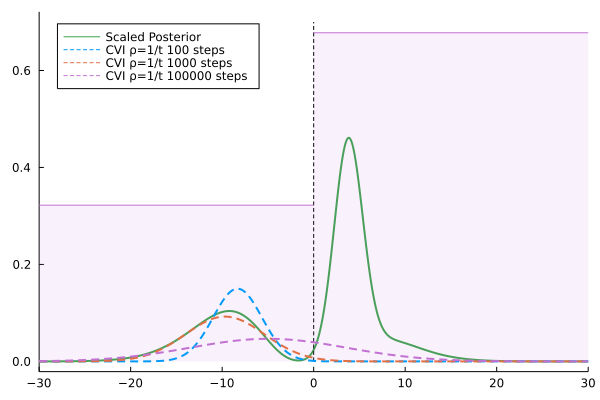

In [14]:
plot(xrange,33.0.*post.(xrange),label="Scaled Posterior",lw=2,color=:green,grid=false,c=3,xlim=(-30,30),legend = :topleft)
vol1 = sum(post.(collect(-100:0.01:0)))
vol2 = sum(post.(collect(0:0.01:100)))
volume1 = vol1/(vol1+vol2)
volume2 = vol2/(vol1+vol2)
plot!(zeros(71),collect(0:0.01:0.7),linestyle=:dash,label=false,color=:black)
plot!(collect(-30:0.1:0), volume1*ones(301), fillrange = zeros(301), fillalpha = 0.1, label = false, legend = :topleft, c=4)
plot!(collect(0:0.1:30), volume2*ones(301), fillrange = zeros(301), fillalpha = 0.1, label = false, legend = :topleft, c=4)
plot!(xrange,cvi1.(xrange),label="CVI ρ=1/t 100 steps",lw=2,c=1,linestyle=:dash)
plot!(xrange,cvi2.(xrange),label="CVI ρ=1/t 1000 steps",lw=2,c=2,linestyle=:dash)
plot!(xrange,cvi3.(xrange),label="CVI ρ=1/t 100000 steps",lw=2,c=4,linestyle=:dash)

In [15]:
savefig("Multimodal1CVInotfixed.pdf")

# Laplace

In [16]:
posterior = prod!(m_forw, m_back)

𝒩(m=-9.22, w=0.07)


In [17]:
laplace(x) = exp(logPdf(posterior,x));

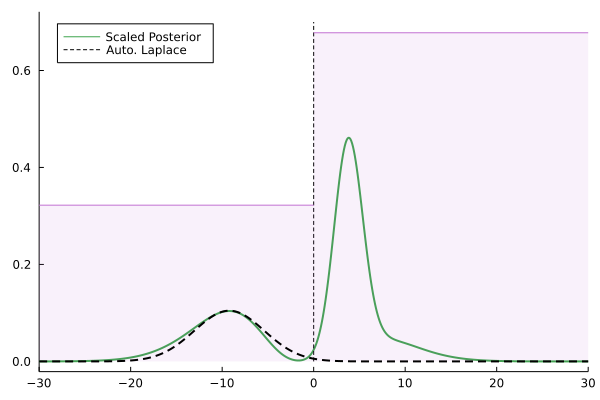

In [18]:
xrange = collect(-30:0.1:30)
plot(xrange,33.0.*post.(xrange),label="Scaled Posterior",lw=2,color=:green,grid=false,c=3,xlim=(-30,30))
vol1 = sum(post.(collect(-100:0.01:0)))
vol2 = sum(post.(collect(0:0.01:100)))
volume1 = vol1/(vol1+vol2)
volume2 = vol2/(vol1+vol2)
plot!(zeros(71),collect(0:0.01:0.7),linestyle=:dash,label=false,color=:black)
plot!(collect(-30:0.1:0), volume1*ones(301), fillrange = zeros(301), fillalpha = 0.1, label = false, legend = :topleft, c=4)
plot!(collect(0:0.1:30), volume2*ones(301), fillrange = zeros(301), fillalpha = 0.1, label = false, legend = :topleft, c=4)
plot!(xrange,laplace.(xrange),label="Auto. Laplace",lw=2,color=:black,linestyle=:dash)

In [19]:
savefig("Multimodal1Laplace.pdf")

# SampleList

In [20]:
samples = sample(m_forw,1000)
pdf(s) = exp(logPdf(m_back,s))
weights = pdf.(samples)
weights = weights./sum(weights)
;

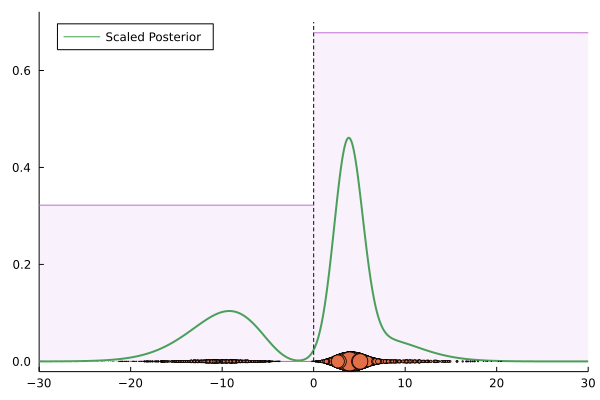

In [21]:
plot(xrange,33.0.*post.(xrange),label="Scaled Posterior",lw=2,color=:green,grid=false,c=3,xlim=(-30,30))
vol1 = sum(post.(collect(-100:0.01:0)))
vol2 = sum(post.(collect(0:0.01:100)))
volume1 = vol1/(vol1+vol2)
volume2 = vol2/(vol1+vol2)
plot!(zeros(71),collect(0:0.01:0.7),linestyle=:dash,label=false,color=:black)
plot!(collect(-30:0.1:0), volume1*ones(301), fillrange = zeros(301), fillalpha = 0.1, label = false, legend = :topleft, c=4)
plot!(collect(0:0.1:30), volume2*ones(301), fillrange = zeros(301), fillalpha = 0.1, label = false, legend = :topleft, c=4)
plot!(samples, zeros(1000), seriestype=:scatter, markersize=2000.0.*weights,c=2,label=false)

In [22]:
savefig("Multimodal1Sample.pdf")

# Moment Match after SampleList

In [23]:
posterior = ProbabilityDistribution(Univariate, SampleList, s=samples, w=weights)
posterior = ProbabilityDistribution(Univariate, GaussianMeanVariance, m=mean(posterior), v=var(posterior))

𝒩(m=0.10, v=61.55)


In [24]:
is(x) = exp(logPdf(posterior,x));

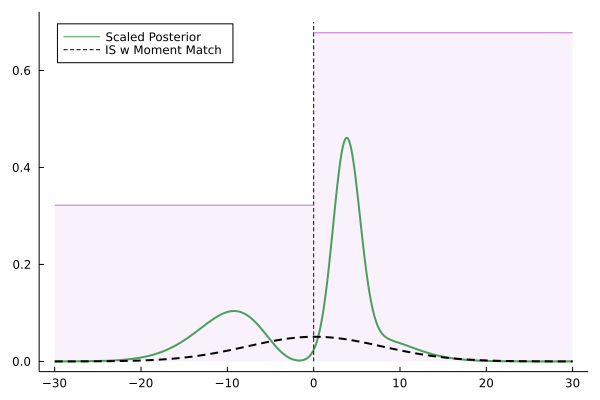

In [25]:
plot(xrange,33.0.*post.(xrange),label="Scaled Posterior",lw=2,color=:green,grid=false,c=3)
vol1 = sum(post.(collect(-100:0.01:0)))
vol2 = sum(post.(collect(0:0.01:100)))
volume1 = vol1/(vol1+vol2)
volume2 = vol2/(vol1+vol2)
plot!(zeros(71),collect(0:0.01:0.7),linestyle=:dash,label=false,color=:black)
plot!(collect(-30:0.1:0), volume1*ones(301), fillrange = zeros(301), fillalpha = 0.1, label = false, legend = :topleft, c=4)
plot!(collect(0:0.1:30), volume2*ones(301), fillrange = zeros(301), fillalpha = 0.1, label = false, legend = :topleft, c=4)
plot!(xrange,is.(xrange),label="IS w Moment Match",lw=2,color=:black,linestyle=:dash)

In [26]:
savefig("Multimodal1MomentMatch.pdf")

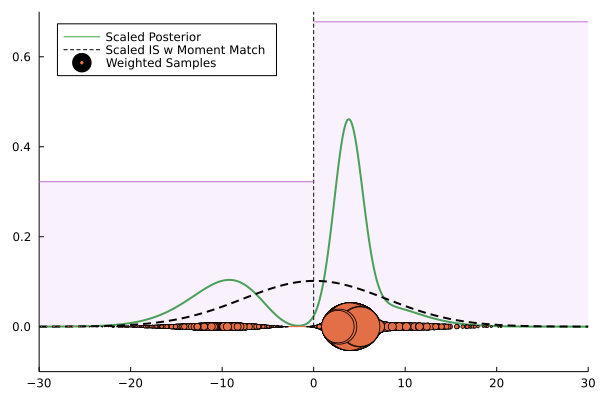

In [44]:
plot(xrange,33.0.*post.(xrange),label="Scaled Posterior",lw=2,color=:green,grid=false,c=3,xlim=(-30,30),ylim=(-0.1,0.7))
vol1 = sum(post.(collect(-100:0.01:0)))
vol2 = sum(post.(collect(0:0.01:100)))
volume1 = vol1/(vol1+vol2)
volume2 = vol2/(vol1+vol2)
plot!(zeros(71),collect(0:0.01:0.7),linestyle=:dash,label=false,color=:black)
plot!(collect(-30:0.1:0), volume1*ones(301), fillrange = zeros(301), fillalpha = 0.1, label = false, legend = :topleft, c=4)
plot!(collect(0:0.1:30), volume2*ones(301), fillrange = zeros(301), fillalpha = 0.1, label = false, legend = :topleft, c=4)
plot!(xrange,2. *is.(xrange),label="Scaled IS w Moment Match",lw=2,color=:black,linestyle=:dash)
plot!(samples, zeros(1000), seriestype=:scatter, markersize=5000.0.*weights,c=2,label="Weighted Samples")

In [45]:
savefig("Multimodal1SampleMomentMatch.pdf")